In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DATA SET

In [2]:
#Load Dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [3]:
#Overview of Dataset Characteristics
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
#Summary of N/A Values
dataset.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

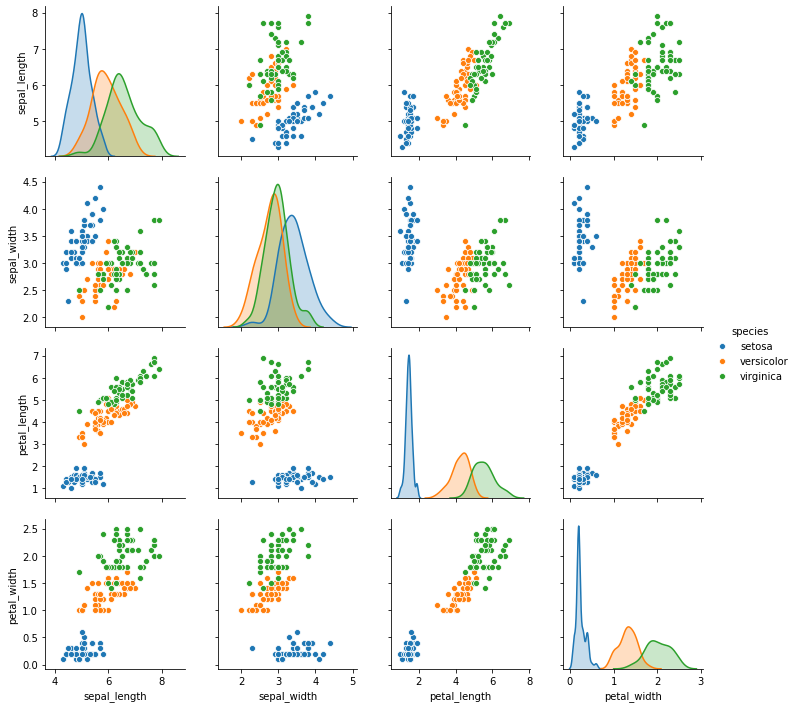

In [5]:
#Visualization of Variables
import seaborn as sns
pairplot = sns.pairplot(dataset, hue="species")
pairplot

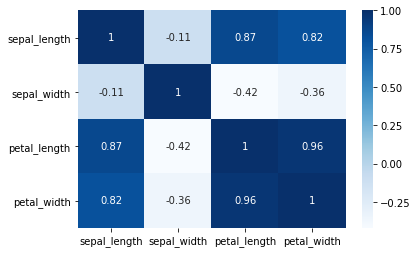

In [6]:
#Visualization of correlations
sns.heatmap(dataset.corr(), annot=True, cmap="Blues")

In [7]:
#Identify Correlated Columns
def correlation (dataset,threshold):
    col_corr = set() #set will contain unique values
    corr_matrix = dataset.corr() # finding correlation between columns
    for i in range(len(corr_matrix.columns)): #Number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #check correlation between columns
                colName = corr_matrix.columns[i] #getting column name
                col_corr.add(colName) #adding correlated columns
                
    return col_corr #returning set of column names

col = correlation(dataset.drop('species', axis = 1), 0.8)
print('Correlated Columns:', col)

Correlated Columns: {'petal_width', 'petal_length'}


In [8]:
#Create X and y variables
X = dataset.drop('species', axis = 1).values
y = dataset['species'].values

In [9]:
#Prepare for Model
#load Library for Training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, stratify = y, random_state = 100)

In [10]:
#Scale X Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_2 = sc.fit_transform(X)

In [11]:
#Import Models
from sklearn.svm import SVC

In [12]:
#Construct Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])

In [13]:
#Define Plot for learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                           X = X_train,
                                                           y = y_train,
                                                           cv = 10,
                                                           train_sizes = np.linspace(.1,1,10),
                                                           scoring = 'accuracy',
                                                           n_jobs = -1)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores,axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', markersize = 5, label = 'validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylim([0.8, 1.01])
    plt.show()

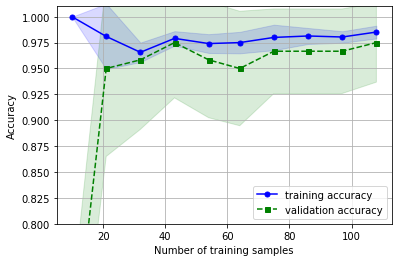

In [14]:
#Lot Learning Curve
plot_learning_curves(pipe_svm)

In [15]:
#Create Table to Compare MLA Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_colwidth', -1)

In [16]:
#Set Grid Search params
param_gridsvm = {'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                'clf__gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                'clf__C': [1,10,100,1000]}

In [17]:
#Optimize Model
cv2 = RepeatedKFold (n_splits = 10, n_repeats = 5, random_state = 100)
opt_svm = GridSearchCV(estimator = pipe_svm, param_grid = param_gridsvm,
                      cv=cv2, verbose = 0, scoring = 'accuracy', n_jobs = -1)

In [18]:
#List of pipelines for ease of iteration
grids = [opt_svm]

In [19]:
#Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'svm'}

In [20]:
#Create Dataframe for MLA Analysis
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for idx, gs in enumerate (grids):
    #Fit grid search
    gs.fit(X_train, y_train)
    
    #Nested CV
    scoresNestedPre = cross_val_score(gs,X_2, y, scoring = 'precision_weighted',
                                   cv = 5, n_jobs = -1)
    scoresNestedRec = cross_val_score(gs, X_2, y, scoring = 'recall_weighted',
                                     cv=5, n_jobs = -1)
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index, 'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(gs.best_score_,2)
    MLA_compare.loc[row_index, 'Precision-NestedCV'] = '{:0.2f} +/- {:0.2f}'.format(np.mean(scoresNestedPre),
                                                                                   (np.std(scoresNestedPre)))
    MLA_compare.loc[row_index, 'Precision-RecallCV'] = '{:0.2f} +/- {:0.2f}'.format(np.mean(scoresNestedRec),
                                                                                   (np.std(scoresNestedRec)))
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(gs.best_params_)
    row_index += 1
    
MLA_compare.sort_values(by = ['Precision-NestedCV'], ascending = False, inplace = True)
MLA_compare

Algorithm Name  Train Accuracy Precision-NestedCV Precision-RecallCV  \
0  svm            0.98            0.97 +/- 0.03      0.97 +/- 0.03       

                                               MLA Parameters  
0  {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid'}